In [1]:
import numpy as np
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D

from PIL import Image
from scipy.optimize import minimize
import f_class
from GP import GP
from GP_grad import GP_grad
from GD import GD
import time
import imageio

#### Noiseless & Noisy

In [2]:
Noise = False # Specify if noisy or not
Noise_level = 0.00 # if noisy, what is the noise sd
'''If use the scaled X and Y, rememeber to scale the noise as well'''

'If use the scaled X and Y, rememeber to scale the noise as well'

#### High-dimensional function $f$

In [3]:
objective = f_class.Hartmann_6(Noise, Noise_level)
# objective = f_class.Alpine(Noise, Noise_level) 
# objective = f_class.Ackley(Noise, Noise_level)
# objective = f_class.Michalewicz(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level, dim=20)
# objective = f_class.Rosenbrock(Noise, Noise_level)
# objective = f_class.Griewank(Noise, Noise_level)
# objective = f_class.Levy(Noise, Noise_level, dim=10)  
objective = f_class.Rastrigin(Noise, Noise_level, dim=10)

f = objective.func
clean_f = lambda x: f_class.Hartmann_6().func(x)
# clean_f = lambda x: f_class.Alpine().func(x)
# clean_f = lambda x: f_class.Ackley().func(x)
# clean_f = lambda x: f_class.Michalewicz().func(x)
# clean_f = lambda x: f_class.Schwefel(dim=20).func(x)
# clean_f = lambda x: f_class.Rosenbrock().func(x)
# clean_f = lambda x: f_class.Griewank().func(x)
# clean_f = lambda x: f_class.Levy(dim=10).func(x)
clean_f = lambda x: f_class.Rastrigin(dim=10).func(x)
B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(B) 
lb = B[:, 0]; ub = B[:, 1]


dim = objective.input_dim
print('dim: ', dim)
print(f( np.array([dim*[0], dim*[0]])))

[[-3.  4.]
 [-3.  4.]
 [-3.  4.]
 [-3.  4.]
 [-3.  4.]
 [-3.  4.]
 [-3.  4.]
 [-3.  4.]
 [-3.  4.]
 [-3.  4.]]
dim:  10
[0. 0.]


#### Finding Optimized Hyperparameter $\sigma, \ell \rightarrow$ Online Update of Hyperparameter

In [4]:
# set seed
seed = 0
def random_draw(n_random_draws=3):
    """ samples some points"""
    # should draw randomly
    return np.random.uniform(lb, ub, size=(n_random_draws, dim))


def optimize_hyper(lb, ub, sample_size=2000):
#     np.random.seed(seed)
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

In [5]:
# # find optimized hyper, if online, skip this part
# gp = GP_grad(B, Noise, Noise_level)
# (ls, var) = optimize_hyper(lb, ub, sample_size=2000)
# del gp
# (ls, var)

#### Sampling

In [6]:
def unique_row(X):
    """
    A functions to trim repeated rows that may appear when optimizing.
    :param X: array to trim repeated rows from
    :return: mask of unique rows
    """
    # Sort array and kep track of where things should go back to
    order = np.lexsort(X.T)
    reorder = np.argsort(order)

    X = X[order]
    diff = np.diff(X, axis=0)
    U = np.ones(len(X), 'bool')
    U[1:] = (diff != 0).any(axis=1)
    return U[reorder]

class close_data():
    def __init__(self, Xc, eps=1):
        self.Xc = Xc
        self.eps = eps
        
    # Iterable
    def __iter__(self):
        return self
    
    # Iterator
    def __next__(self):
        Xn = self.Xc + self.eps*np.random.uniform(-1, 1, self.Xc.shape)
        return Xn
    
def is_new(Xn, Xpast=None):
    if Xpast is None:
        return True
    else:
        return np.array([(i != Xn).any() for i in Xpast]).all()

def close_draw(Xc, n_random_draws=4, close=1, Xpast=None):
    # sample from a small 2d box with center given Xc, no repeated points
    X = np.zeros((n_random_draws, dim))
    X[0] = Xc
    counter = 0
    gc = close_data(Xc)
    while True:
        Xn = next(gc)
        if LA.norm(Xn - Xc) > 5e-2 and is_new(Xn, Xpast) == True:
            counter += 1
            X[counter] = Xn
        if counter == n_random_draws-1:
            break
    return X

### Grid

In [7]:
# n_Grid = dim
# G = np.zeros((dim, n_Grid))
# for i in range(dim):
#     G[i] = np.linspace(lb[i], ub[i], n_Grid)

# Grid = np.vstack( [axis.flatten() for axis in np.meshgrid(*(G[i] for i in range(G.shape[0])))] ).T
# Grid.shape

### Grid Approx Gradient

In [8]:
# # approximate the gradient
# from scipy import optimize

# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape

In [9]:
# # 3d plot of the gradient
# # approximate the gradient
# from scipy import optimize

# # optimize.approx_fprime(x, clean_Ackley_1d, eps)
# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape
# g1 = approx_grad[:, 0]
# g2 = approx_grad[:, 1]
# g1, g2

# BO

In [10]:
MAX = 300 # function observations

## Gradient-based Method

##### 1. Setup

In [11]:
# initial data
setup = 1
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))

# sample from a small 2d box
# Xc = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))
# X = close_draw(Xc, n_random_draws=setup)

# X = np.vstack([X, np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))])

In [12]:
gp = GP_grad(B, Noise, Noise_level)
# gp.set_hyper(ls, var)  # if online, skip

gp.set_data(X, f(X))
ls, var = gp.optimize()
gp.set_hyper(ls, var)
gp.fit()

# w: starting point of GD
w = X[0].reshape(1, dim)
history_w = []
history_f = []

##### 2. Warm up

In [13]:
# gp.posterior_full_grad('full', dim*[w]), gp.posterior_grad(w)
warmup = 30
history_warmup = []
for i in range(1, warmup+1):
    b = np.log(i)
    w, fw = gp.ucb_minimize(b)
    X = np.vstack([X, w])
    
    print(i, end = ', ')
    print('w: ', w, end = ', ')
    print('f(w): ', f(w).item(), end = ', ')
    print()
    
    gp.add_data(w.reshape(1, dim), f(w))
    
    if i % 5 == 0:
        ls, var = gp.optimize()
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    history_warmup.append( (w, f(w)) )
    
X_fix = X

1, w:  [-3.  4.  4. -3. -3.  4. -3.  4.  4.  4.], f(w):  132.0, 
2, w:  [ 4.  4.  4. -3.  4. -3.  4. -3.  4.  4.], f(w):  139.0, 
3, w:  [-3.  4. -3. -3.  4. -3.  4.  4. -3. -3.], f(w):  118.0, 
4, w:  [ 4.  4.  4.  4. -3.  4.  4. -3. -3.  4.], f(w):  139.0, 
5, w:  [-3.  4. -3.  4. -3.  4. -3.  4.  4. -3.], f(w):  125.0, 
  # Optimal (ls, var) =  (10.0, 7065.61005772708)
6, w:  [-3. -3.  4.  4.  4. -3. -3.  4.  4. -3.], f(w):  125.0, 
7, w:  [ 4. -3. -3. -3. -3.  4.  4.  4. -3. -3.], f(w):  118.0, 
8, w:  [-3.  4. -3.  4.  4.  4. -3. -3. -3.  4.], f(w):  125.0, 
9, w:  [ 4. -3. -3. -3.  4.  4. -3. -3.  4. -3.], f(w):  118.0, 
10, w:  [-3. -3.  4. -3. -3. -3. -3. -3. -3.  4.], f(w):  104.0, 
  # Optimal (ls, var) =  (10.0, 4240.672635752481)
11, w:  [ 4. -3. -3.  4.  4. -3. -3.  4. -3. -3.], f(w):  118.0, 
12, w:  [-3. -3.  4.  4.  4.  4.  4.  4. -3.  4.], f(w):  139.0, 
13, w:  [-3. -3. -3.  4. -3. -3.  4. -3.  4. -3.], f(w):  111.0, 
14, w:  [ 4.  4. -3.  4. -3. -3.  4.  4. -3.  4.],

##### 3. Optimize via GD

In [14]:
w, _ = gp.ucb_minimize(1)
# w = gp.X[np.argmin(gp.y)]
optimizer = GD(gp, B, w, f)

from scipy import optimize
eps = np.sqrt(np.finfo(float).eps)
gp.grad(w), gp.grad_sample(w), optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)

(array([[-3.61396943,  4.70123755,  4.85948246, -3.27912997, -1.51132887,
          3.3574677 ,  3.0614951 ,  5.24679331,  3.18166798, -1.9703443 ]]),
 array([[-5.1226646 ,  6.65616046,  8.01762686,  1.28803242, -2.78998483,
          1.76627251,  3.88719805,  2.60912502,  6.64898962,  1.6503782 ]]),
 array([ 8.00000286, -5.99999714, -5.99999714,  8.00000286,  8.00000286,
        -5.99999714, -5.99999714, -5.99999714, -5.99999714,  8.00000286]))

In [15]:
np.set_printoptions(precision=4)
stall = False
cost = setup + warmup

desc = -optimizer._grad()

lr = 0.1
while cost <= MAX:
    # update w 
    if optimizer.contFail >= 7 or stall:
        lr = 0.1
        print()
        print('New Local Search: ',)
        print('Fail = ', optimizer.contFail, end = ', ')
        print('Norm = ', LA.norm(desc))
        
#         # random draw
#         w = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))
        
#         UCB draw
        w, _ = gp.ucb_minimize(cost)
        gp.add_data(w.reshape(1, -1), f(w))
        
        # many UCB draws, pick the best
#         history_warmup = []
#         for i in range(1, warmup+1):
#             b = np.log(i)
#             w, fw = gp.ucb_minimize(b)
#             X = np.vstack([X, w])

# #             print(i, end = ', ')
# #             print('w: ', w, end = ', ')
# #             print('f(w): ', f(w).item(), end = ', ')
# #             print()

#             gp.add_data(w.reshape(1, dim), f(w))
#             if i % 5 == 0:
#                 ls, var = gp.optimize()
#                 print('  # Optimal (ls, var) = ', (ls, var))
#             gp.fit()
#             history_warmup.append( (w, f(w)) )

#         w = X[np.argmin(f(X))]
            
        # change back setting
        cost += 1
        stall = False
        
        history_w.append(optimizer.history_w)
        history_f.append([f(w).item() for w in optimizer.history_w])
        optimizer = GD(gp, B, w, f)
    else:
        lr = lr*0.97
        w, desc = optimizer.update_sample(y_best=np.min(f(gp.X)), lr=lr)
        if is_new(w, gp.X) == False:
            print('  ** hit past points')
            stall = True
            continue
            
        gp.add_data(w.reshape(1, -1), f(w))
        cost += 1
    
    
    # online hyper udpate + fitting GP with new query w
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()

    m, v = gp.posterior_full_grad('full', dim*[w])
    v = np.sqrt(np.diag(v))
    print(cost, end = '. ')
    print('    w: ', np.squeeze(w), end = ', ')
    print('    f(w): %.6f ' % f(w).item())
    print('       d(w): ', np.squeeze(m))
    print('       s.d: ', np.squeeze(v))
    print('       g(w):', optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps))
    print('       lr: %.4f' % lr)
    print()
        
print('Max Cost reached = ', cost)
history_w.append(optimizer.history_w)
history_f.append([f(w).item() for w in optimizer.history_w])

GD loop:  0
32.     w:  [ 4.     -3.     -3.      4.      4.     -3.     -3.     -3.     -2.9931
  3.9822],     f(w): 117.888514 
       d(w):  [-2.7096  4.496   4.6026 -2.781  -0.7117  2.6758  2.5235  4.5836  2.865
 -0.8028]
       s.d:  [2.8686 3.3145 3.3024 3.3029 2.8954 3.1464 3.2741 3.0756 3.3786 2.663 ]
       g(w): [ 8.     -6.     -6.      8.      8.     -6.     -6.     -6.     -3.2767
  0.9371]
       lr: 0.0970

GD loop:  0
  # Optimal (ls, var) =  (10.0, 1534.1471457098955)
33.     w:  [ 3.9997 -3.     -3.      4.      3.984  -3.     -2.9971 -3.     -3.
  3.9823],     f(w): 117.824981 
       d(w):  [-2.814   4.5578  4.8594 -2.8497  2.272   3.1939  2.3844  4.8652  5.0886
 -1.1626]
       s.d:  [2.656  3.0696 3.052  3.0591 1.252  2.8847 3.0303 2.8399 2.5819 2.4494]
       g(w): [ 7.8644 -6.     -6.      8.      1.6676 -6.     -4.859  -6.     -6.
  1.0096]
       lr: 0.0941

GD loop:  0
34.     w:  [ 4.     -3.     -3.      4.      3.9704 -3.     -3.     -3.     -3.
  3.9717],

  # Optimal (ls, var) =  (1.3458402535376643, 12524.261019927697)
54.     w:  [-1.6026  2.259  -2.7994  2.171   2.2612 -0.9136  3.0119  3.1027  3.7437
  3.7368],     f(w): 148.995459 
       d(w):  [ 22.26    55.7723  27.8021 102.5552  41.4178 -15.4487  12.7523   6.7444
 -28.2689 -20.6292]
       s.d:  [25.6686 69.2514 48.5091 40.1826 54.2678 41.9528 70.9969 40.3484 67.181
 56.5705]
       g(w): [ 34.5478  67.2489  54.2324  59.583   67.1979  30.6175  10.7281  43.9987
 -55.2949 -55.142 ]
       lr: 0.0833

GD loop:  0
55.     w:  [-1.6078  2.2185 -2.8035  2.1578  2.2823 -0.9074  3.0005  3.1019  3.7956
  3.7737],     f(w): 141.715174 
       d(w):  [ 21.5055  66.1005  26.5057  97.2893  29.9419 -18.7926  15.4753   5.5508
 -46.356  -34.1291]
       s.d:  [25.848  63.5818 48.6316 35.6691 42.0582 41.1584 70.7754 40.3292 42.6843
 41.7269]
       g(w): [ 36.1612  66.0442  53.7109  56.8886  66.104   32.7073   6.2023  43.7247
 -52.6789 -54.5921]
       lr: 0.0808

GD loop:  0
56.     w:  [-1.615

GD loop:  0
77.     w:  [-1.9157  1.98   -2.9597  1.9708  1.9573 -1.0185  3.0053  2.9407  3.9671
  4.    ],     f(w): 77.785134 
       d(w):  [ 30.8364  20.306   45.0203 -19.6444  -2.4314 -10.1015   4.4702  -4.171
  -5.6151  -0.8783]
       s.d:  [ 7.614  15.1308 12.8866 17.5945 13.1775 20.7772 17.2446 14.4545 13.9406
 14.6862]
       g(w): [ 27.9062  -3.917    9.8351  -7.5241 -12.7506  -9.3241   8.1012 -16.9837
  -4.9483   8.    ]
       lr: 0.0413

GD loop:  0
  # Optimal (ls, var) =  (0.966688091252292, 10564.130227599386)
78.     w:  [-1.9321  1.9575 -2.9835  1.9788  1.9631 -1.0141  2.9961  2.9373  3.9712
  3.994 ],     f(w): 77.232247 
       d(w):  [ 27.4198 -18.0379  27.5611  -3.2911   6.3086   4.0204   1.73   -27.0601
   8.9836 -15.8684]
       s.d:  [10.2339 10.8392 14.6372 20.105  16.8443 24.7283 20.9252 15.182  16.7787
 17.5124]
       g(w): [ 22.1513 -12.6666   0.524   -4.4    -10.5273  -7.5841   4.4646 -18.2601
  -3.3479   5.6163]
       lr: 0.0401

GD loop:  0
79.     w:

GD loop:  0
95.     w:  [-1.989   1.9948 -2.9853  1.9859  1.9824 -0.9954  2.9939  2.9835  4.
  3.9752],     f(w): 75.737314 
       d(w):  [ 3.2371  3.5144 -2.0058 -1.4707  0.8653 -2.7974  3.5994 -4.9453  1.6944
 -3.2146]
       s.d:  [2.351  5.8122 4.9351 4.5277 3.7579 3.9985 4.5705 3.9761 3.853  4.3588]
       g(w): [ 0.3599  1.9381 -0.1882 -1.5764 -2.9663 -0.1924  3.5863 -0.529   8.
 -1.7987]
       lr: 0.0239

GD loop:  0
  # Optimal (ls, var) =  (1.2747578696297726, 44120.465291762135)
96.     w:  [-1.9905  1.9754 -2.9857  1.9795  1.9813 -1.0002  2.9881  2.9857  3.9943
  3.9704],     f(w): 75.760848 
       d(w):  [ 3.1812 -4.9655  0.0105 -4.1407 -0.4256 -3.7066  1.0767 -2.6192  1.341
 -3.8247]
       s.d:  [2.5403 2.3086 4.8229 3.9644 3.8545 3.178  4.2773 4.0792 3.9561 2.9855]
       g(w): [-0.2396 -5.7092 -0.3173 -4.1132 -3.3997 -2.0762  1.2807  0.35    5.74
 -3.6809]
       lr: 0.0232

GD loop:  0
97.     w:  [-1.9908  1.9808 -3.      1.9875  1.9839 -1.      2.9851  2.9839  3.9

GD loop:  0
  # Optimal (ls, var) =  (1.175295265815995, 27548.32053776819)
117.     w:  [ 0.9971  3.125  -2.4265  2.387   3.9961 -0.9741  3.9708  2.9939  2.0524
  2.9846],     f(w): 117.469853 
       d(w):  [  2.6893  43.2038  -6.4313  18.5643  -8.5586 -13.8698 -54.7217  -3.7528
  35.9739 -58.9485]
       s.d:  [20.7499 40.5881 40.2951 35.4118 22.4548 28.463  34.0958 29.2251 37.7869
 39.8907]
       g(w): [  0.8334  50.665  -32.8588  45.7313   6.4375   8.2147  -3.5215   3.5726
  24.408   -0.1175]
       lr: 0.0596

GD loop:  0
118.     w:  [ 1.0022  3.144  -2.4441  2.3811  3.9998 -0.9581  3.9943  2.9799  2.0274
  3.0155],     f(w): 118.664329 
       d(w):  [  1.3908  88.6969 -44.791   27.5752   0.6287   9.3089 -19.9848 -18.7767
   9.6283 -25.1409]
       s.d:  [22.9098 28.0967 34.2716 37.5461 24.8694 27.8268 29.9056 30.768  36.2462
 35.3194]
       g(w): [  2.8636  55.6924 -26.4884  47.4475   7.9082  14.4484   5.7432  -1.9418
  14.8109  12.1593]
       lr: 0.0578

GD loop:  0
119.  

  # Optimal (ls, var) =  (1.0541824137174143, 19951.60308705311)
135.     w:  [ 1.027   2.9639 -2.1687  2.0465  3.9671 -0.9581  3.9684  2.9911  1.9614
  2.9944],     f(w): 79.899018 
       d(w):  [  3.2838  17.3081 -35.1502  51.7295  -8.2697  -8.5372   3.61   -11.373
   2.1162  -2.8816]
       s.d:  [16.6988 18.1943 19.8262 16.5038 11.162  17.9224 19.1108 11.3295 18.3127
 17.4904]
       g(w): [ 12.6783  -8.1943 -59.1518  22.1983  -4.9741  14.4219  -4.4427   2.4539
 -11.151    3.7954]
       lr: 0.0344

GD loop:  0
136.     w:  [ 1.0294  2.9485 -2.153   2.03    3.9759 -0.9715  3.9667  2.9887  1.9709
  2.9948],     f(w): 78.613207 
       d(w):  [  8.2292  12.6371 -29.3134  49.5936  -8.9042 -19.7357  -2.2852 -14.9268
   7.1995  -7.3359]
       s.d:  [16.6505 13.4341 21.1842 17.1369 13.6892 14.0679 14.308  12.5467 18.8648
 16.2417]
       g(w): [ 13.5865 -14.0668 -55.8287  15.8432  -1.517    9.2369  -5.0989   1.5245
  -7.4977   3.9453]
       lr: 0.0334

GD loop:  0
137.     w:  [ 1.038

153.     w:  [ 0.9948  2.986  -1.9817  2.0031  3.9859 -0.9847  3.9607  2.9853  1.9851
  2.9803],     f(w): 72.787812 
       d(w):  [-0.1992  4.0154  1.3684  2.1145 -0.022   4.9947 -4.0647  3.6844 -4.8224
  6.4581]
       s.d:  [4.3044 3.2438 2.0484 3.6158 4.3669 3.9276 4.4039 5.9849 5.8586 7.5311]
       g(w): [-0.054   0.4692  3.2597  5.2433  2.413   4.0464 -7.4257  0.1756 -1.8979
 -1.7852]
       lr: 0.0199


New Local Search: 
Fail =  7, Norm =  18.71896401555485
154.     w:  [-2.787   3.5066  3.23   -2.9554 -2.311   3.9952  3.9181  0.9994 -2.0623
  0.801 ],     f(w): 141.249249 
       d(w):  [-6.7680e-12  1.0855e-11  3.4252e-11  7.6020e-13 -3.0632e-11 -2.0587e-11
 -2.8490e-10  1.2145e-10  2.5643e-10  1.2186e-10]
       s.d:  [204.9217 204.9217 204.9217 204.9217 204.9217 204.9217 204.9217 204.9217
 204.9217 204.9217]
       g(w): [ 55.5697   4.4204  68.7953  11.4525 -62.8961   6.0992 -23.0863   1.781
 -28.1112 -58.0336]
       lr: 0.1000

GD loop:  0
155.     w:  [-2.777   3.5059 

GD loop:  0
172.     w:  [-2.9762  3.5112  3.0331 -2.9913 -2.0161  3.9402  3.9698  1.0071 -1.9588
  1.0166],     f(w): 102.209058 
       d(w):  [ 21.4633  25.7251  11.4947   6.6901 -23.8501  -6.8483  10.0534  14.6087
  31.5159   2.274 ]
       s.d:  [35.3498 34.4078 21.0121 29.0088 33.8172 27.3353 37.3752 27.9012 39.1266
 25.6079]
       g(w): [  3.4149   2.603   19.0268  -2.5329 -10.3836 -15.1592  -3.9026   4.8179
  12.1584   8.5728]
       lr: 0.0578

GD loop:  0
173.     w:  [-2.9752  3.5162  2.9944 -3.     -2.0178  3.9515  3.9821  1.0309 -1.9524
  0.9984],     f(w): 101.890653 
       d(w):  [ 17.5848  25.5251  17.7259  10.2369 -19.6772  -9.2725   5.1136   6.0711
  31.4195   8.1952]
       s.d:  [35.9973 35.9885 11.4954 26.6808 33.6677 27.0987 33.1403 15.0864 39.6014
 24.4144]
       g(w): [  3.8142   0.6333   3.7749  -6.     -11.0677 -10.9496   0.9101  14.1811
  14.5936   1.3742]
       lr: 0.0561

GD loop:  0
  # Optimal (ls, var) =  (0.9546051535185727, 13445.310147669281)
174.

  # Optimal (ls, var) =  (0.8821648776898803, 9170.188056095105)
189.     w:  [-1.546   0.0976  0.8331  0.9372 -2.8923  2.6847  1.4948 -0.2876 -1.1661
  1.5275],     f(w): 126.086744 
       d(w):  [ 31.5549  29.6078 -23.4975 -20.6896  71.9639 -34.9826   8.1917 -66.3782
 -84.0147 -16.633 ]
       s.d:  [94.4741 80.8307 98.5623 47.216  60.9728 48.0743 37.5878 38.7869 41.7559
 43.1047]
       g(w): [ 14.8298  36.3621 -52.7843 -22.2776  33.5759 -52.2518   5.0295 -61.6631
 -56.6286  -7.7534]
       lr: 0.0808

GD loop:  0
190.     w:  [-1.5502  0.0446  0.851   0.9415 -2.9244  2.6942  1.4933 -0.2677 -1.1318
  1.5442],     f(w): 118.928633 
       d(w):  [ 38.0937  -1.2485 -15.4541 -30.0754  84.7328 -34.4356  18.2773 -61.1361
 -72.3329  -9.1876]
       s.d:  [94.11   42.1509 96.9134 46.3456 60.6293 49.6623 34.3753 37.6892 37.0522
 37.9008]
       g(w): [ 16.4093  17.4536 -48.9062 -20.7097  22.8818 -53.6252   5.6182 -62.9771
 -48.5476 -14.1472]
       lr: 0.0784

GD loop:  0
191.     w:  [-1.

  # Optimal (ls, var) =  (1.3359388471908187, 57792.04664778634)
207.     w:  [-1.5388 -0.0429  1.022   0.993  -2.9914  2.9152  1.6391  0.0077 -0.9744
  1.8587],     f(w): 70.756934 
       d(w):  [ -2.8827 -11.1845  15.2957 -21.8719   1.3975 -26.3792 -49.3748 -37.4089
  -4.586  -39.9298]
       s.d:  [21.6698 26.6382 17.1913 30.808  12.6557 23.9082 17.0095 21.1745 23.214
 15.1715]
       g(w): [ 12.0968 -16.8103  10.6957  -0.7823  -2.6068 -26.0933 -44.9065   3.062
   8.1049 -45.0222]
       lr: 0.0467

GD loop:  0
208.     w:  [-1.5527 -0.0438  1.0157  1.0012 -2.9823  2.9061  1.6619  0.0345 -0.9632
  1.8735],     f(w): 69.375532 
       d(w):  [-15.9737 -18.6539  11.2984  -3.5871   1.2408 -46.6543 -40.849  -17.499
   8.7746 -38.0024]
       s.d:  [19.905  27.5132 18.2345 27.9329 14.6262 16.3544 16.7651 16.7812 23.0988
 16.5878]
       g(w): [ 17.3135 -17.1584   8.2228   2.4908   0.9961 -29.1513 -50.1241  13.599
  12.4803 -41.0909]
       lr: 0.0453

GD loop:  0
209.     w:  [-1.5449 -

  # Optimal (ls, var) =  (1.0819717528680741, 25696.39153531008)
225.     w:  [-1.5908  0.0087  0.9704  0.9848 -2.9772  2.981   1.9594  0.0295 -0.9981
  2.0079],     f(w): 50.391990 
       d(w):  [  5.8287   3.8036 -13.4968  -2.5825  -3.8181  13.4704 -28.1048 -14.8343
   9.3487   5.6111]
       s.d:  [ 8.1976 10.1127  7.9941  9.3961  7.2217 12.5805  5.6393 11.8074 15.1528
  9.9481]
       g(w): [ 30.7378   3.4562  -9.6681  -4.0126   3.0171  -1.5113 -11.9504  11.6248
  -1.2604   7.1279]
       lr: 0.0270

GD loop:  0
226.     w:  [-1.5969  0.0123  0.9773  0.9889 -2.9735  2.9856  1.9745  0.0424 -1.0083
  2.0019],     f(w): 50.198370 
       d(w):  [  6.8998   8.8006  -2.7633   2.4957   4.5824  13.6514 -17.6114  -3.9509
  -9.9303  -3.4454]
       s.d:  [ 9.4039 10.4944  7.1083  9.7867  7.5559 13.5001  4.5424 10.63   11.3413
  8.8901]
       g(w): [32.7314  4.8893 -6.9756 -2.4037  4.4727  0.3091 -6.0833 16.6448 -5.2754
  4.7346]
       lr: 0.0262

GD loop:  0
227.     w:  [-1.6034  0.0128

  # Optimal (ls, var) =  (1.9335232089422885, 98466.85130790297)
243.     w:  [-1.7902  0.0055  1.0064  1.0043 -2.9705  2.9771  1.9947  0.0131 -1.0144
  1.997 ],     f(w): 39.785509 
       d(w):  [ 62.3094  -2.6321  -9.6037  11.4961 -11.9855  15.9391   6.5896 -20.4747
  27.7644  25.5419]
       s.d:  [0.5561 2.4187 2.0254 2.6276 3.1323 2.5768 2.1225 2.3895 3.5531 3.117 ]
       g(w): [57.2583  2.1883  4.5404  3.7146  5.6501 -3.0546  1.9064  5.2071 -7.7102
  2.7993]
       lr: 0.0156

GD loop:  0
244.     w:  [-1.8027  0.0056  1.0085  1.0034 -2.969   2.9742  1.9933  0.0168 -1.0184
  1.9919],     f(w): 39.149309 
       d(w):  [ 59.9994   1.6214   4.807   -6.3403  15.0216  -4.8034   4.293    4.2709
 -12.6394  -4.4435]
       s.d:  [0.5974 2.7322 1.7267 2.4235 2.3799 2.1214 2.3215 1.4354 1.8672 2.4738]
       g(w): [55.8144  2.2378  5.3681  3.3428  6.2208 -4.1889  1.3614  6.6479 -9.2866
  0.7832]
       lr: 0.0151

GD loop:  0
245.     w:  [-1.8165  0.0053  1.0073  1.0041 -2.972   2.9755

  # Optimal (ls, var) =  (1.113054551618434, 26804.811791723016)
261.     w:  [-1.979  -0.0075  0.9942  0.9977 -2.9734  2.9782  1.9875 -0.0037 -0.998
  1.9903],     f(w): 32.910135 
       d(w):  [ 2.6153 -1.5854 -0.7572  1.7769  0.2532 -0.73   -2.4185 -0.7463 -1.1698
  1.3062]
       s.d:  [0.4791 1.2233 1.3284 1.6544 1.0967 2.0211 1.4481 1.6295 2.6849 2.0316]
       g(w): [ 4.3167 -2.974  -0.3156  1.0849  4.4873 -2.6333 -0.939  -1.4784 -1.2075
  0.1502]
       lr: 0.0090

GD loop:  0
262.     w:  [-1.9829e+00 -3.3228e-03  9.9376e-01  9.9893e-01 -2.9771e+00  2.9738e+00
  1.9876e+00 -1.3746e-03 -9.9991e-01  1.9903e+00],     f(w): 32.890701 
       d(w):  [ 1.1652 -0.5201 -0.534   1.0004  0.9028  0.2385 -2.5331 -0.5284 -0.2183
  2.0766]
       s.d:  [0.3783 0.864  0.9795 1.0244 0.907  1.298  1.3147 1.35   1.985  1.7227]
       g(w): [ 2.7548 -1.3183 -0.4738  1.5741  3.0373 -4.3339 -0.9073 -0.5454 -1.963
  0.1446]
       lr: 0.0087

GD loop:  0
263.     w:  [-1.9861e+00 -1.8566e-03  9.96

  # Optimal (ls, var) =  (2.656171977437988, 82541.7639298207)
279.     w:  [-1.7102e+00 -6.8578e-01  1.0978e+00  1.0214e+00 -2.6154e+00  3.0727e+00
 -8.1633e-01  2.3814e-03 -1.0650e+00  1.9264e+00],     f(w): 82.093384 
       d(w):  [ 26.3838  32.542   37.1917  -4.4109  45.7178  76.5672  36.405   -4.5252
 -22.1645 -13.1092]
       s.d:  [3.7716 5.9368 8.0871 6.0445 4.8258 6.5439 2.6389 4.6178 5.9771 2.8712]
       g(w): [ 57.4569  56.4148  38.4212  10.4742  36.4499  33.8667  55.8212   0.9449
 -27.076  -24.1928]
       lr: 0.0715

GD loop:  0
280.     w:  [-1.7287 -0.7071  1.0732  1.0216 -2.6398  3.027  -0.838   0.0071 -1.0535
  1.9365],     f(w): 75.132378 
       d(w):  [ 12.7428  20.8488  15.2499  -7.9438  45.3899  56.4807  38.0019  -9.9426
 -16.4258 -28.0713]
       s.d:  [4.5908 5.0314 6.4218 6.9322 5.9101 5.4406 3.0192 5.2742 5.842  3.5224]
       g(w): [ 58.8137  59.1515  30.0219  10.5417  43.0863  16.6746  51.7923   2.8187
 -22.8373 -20.5379]
       lr: 0.0694

GD loop:  0
281

  # Optimal (ls, var) =  (0.699361853164247, 3986.9311214297627)
297.     w:  [-1.9534 -0.9485  0.9699  0.9809 -2.9065  2.9313 -1.0395 -0.0231 -1.0282
  1.9613],     f(w): 34.294681 
       d(w):  [ 16.3185  25.7194 -13.2756 -14.0545  38.1423 -14.8014 -25.9163 -11.1106
  11.0566 -21.8509]
       s.d:  [16.0664 19.2025 17.1974 15.1017 15.3662  9.7727 17.6864 13.6042 24.0553
 15.0278]
       g(w): [ 14.2266  18.088   -9.8718  -5.5726  29.0021 -20.4269 -17.5269  -9.1403
 -13.1132 -11.2193]
       lr: 0.0413

GD loop:  0
298.     w:  [-1.974  -0.9516  0.9637  0.9931 -2.9202  2.9443 -1.0218 -0.0098 -1.0249
  1.9726],     f(w): 32.978942 
       d(w):  [  4.5073  20.8036 -14.6083  -6.9447  38.9637  -8.2758 -13.8707  -0.2165
  17.2326 -18.0732]
       s.d:  [16.1316 21.5568 20.346  15.5866 17.3174 11.5999 17.4186 13.1016 25.3802
 17.766 ]
       g(w): [  6.2895  16.8933 -12.2849  -0.7194  24.3525 -15.6663 -10.6226  -3.8881
 -11.8351  -6.8217]
       lr: 0.0401

GD loop:  0
299.     w:  [-1.97

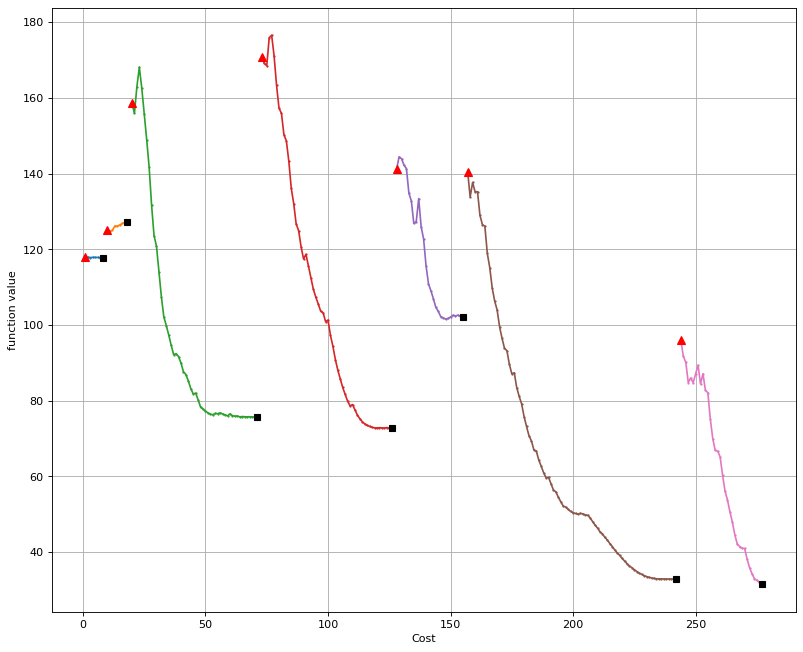

In [16]:
pl.figure(figsize=(12, 10), dpi=80)
axis = 1
for l in history_f:
    pl.plot(np.arange(axis, axis+len(l)), l, "-o", markersize=1)
    pl.plot(axis, l[0], "r^", markersize=8)
    pl.plot(axis+len(l)-1, l[-1], "ks")
    axis += len(l) + 1 # COST includes setup


pl.plot()

pl.xlabel("Cost")
pl.ylabel("function value")
pl.grid(True)

## Minima of GD

In [17]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

(array([-1.9907, -0.9716,  0.9956,  1.0075, -2.9558,  2.9667, -1.0056,
        -0.012 , -1.0156,  2.0157]),
 31.47993239545294,
 300)

In [18]:
gp.get_hyper()

{'var': 4518.392814309832, 'lengthscale': 0.7163371004778273}

In [19]:
# # only for backtracking
# pl.figure(figsize=(10, 6), dpi=80)
# # pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### *Thompson Sampling, UCB*

In [20]:
### Thompson Sampling
import os
gp.clear()
# gp.set_hyper(ls, var) # if online update hyper, skip

# init cost
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = X_fix

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

history = [(w, f(w)) for w in X]

In [21]:
cost = setup + warmup
while cost < MAX:
    # posterior of GP given gp.X, gp.y
#     mu, covar = gp.posterior(Grid)
#     mu = np.squeeze(mu)
#     s = np.sqrt(np.diag(covar))
    
    # posterior of GP derivative given gp.X, gp.y
    # partial x1
#     gp.set_p(0)
#     mu_grad_1, covar_grad_1 = gp.posterior_grad(Grid)
#     mu_grad_1 = np.squeeze(mu_grad_1)
#     s_grad_1 = np.sqrt(np.diag(covar_grad_1))

#     # partial x2
#     gp.set_p(1)
#     mu_grad_2, covar_grad_2 = gp.posterior_grad(Grid)
#     mu_grad_2 = np.squeeze(mu_grad_2)
#     s_grad_2 = np.sqrt(np.diag(covar_grad_2))
    
    # 1. Thompson Sampling
#     L = np.linalg.cholesky(covar + 1e-6*np.eye(n_Grid**dim)) # LL^T = Sigma (posterior covariance)
#     f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid**dim, 1)))
#     arg_min = np.argmin(f_post)
#     w = Grid[arg_min]
    
    # 2. GP_UCB
    b = np.log(cost)
#     arg_min = np.argmin(mu.reshape(-1,1) - np.sqrt(b)*s.reshape(-1, 1)) # discrete version
#     w = Grid[arg_min]
#     w, fw = gp.ucb_minimize(b)
    w, fw = gp.EI_minimize(y_best=np.min(f(gp.X)))
    if is_new(w, gp.X) == False:
        print('visit before, ignore ', w)
        continue
    
    
#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(24, 21))

#     # plot function (ax1, ax2)
#     im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax2)

#     im1 = ax1.contour(X1, X2, functions.Ackley_2().func(Grid).reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax1)
#     fig.colorbar(im2, ax=ax1)

#     ax1.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax1.plot(w[0], w[1], 'ro')
#     ax1.title.set_text("Noisy Ackley")
#     ax2.title.set_text("Standard Deviation")
    
    
#     # plot derivative in (ax3, ax4), (ax5, ax6)
#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, g1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

    
#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, g2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")

#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('2D_Plots/Ackley/' + filename)
#     pl.show()  
    print(cost, end = '. ')
    print('w: ', w)
    print('  f(w): ', f(w).item())
    print()
    
    history.append( (w, f(w)) )
    gp.add_data(w.reshape(1, dim), f(w))
    
    if cost % 10 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    cost += 1

31. w:  [ 4. -3. -3. -3. -3. -3. -3. -3. -3.  4.]
  f(w):  104.0

32. w:  [-3. -3. -3.  4. -3. -3.  4. -3. -3. -3.]
  f(w):  104.0

33. w:  [ 4. -3. -3.  4. -3.  4. -3. -3. -3. -3.]
  f(w):  111.0

34. w:  [-3. -3.  4. -3.  4.  4. -3. -3. -3. -3.]
  f(w):  111.0

35. w:  [ 4. -3. -3.  4.  4. -3. -3. -3. -3.  4.]
  f(w):  118.0

36. w:  [ 4.  4. -3.  4.  4.  4.  4. -3.  4. -3.]
  f(w):  139.0

37. w:  [-3.  4. -3. -3. -3.  4.  4. -3. -3.  4.]
  f(w):  118.0

38. w:  [-3. -3. -3. -3. -3. -3. -3.  4. -3. -3.]
  f(w):  97.0

39. w:  [ 4. -3. -3. -3.  4. -3.  4. -3. -3. -3.]
  f(w):  111.0

40. w:  [ 4. -3. -3. -3. -3. -3. -3. -3.  4. -3.]
  f(w):  104.0

  # Optimal (ls, var) =  (10.0, 1474.9027089641936)
41. w:  [-3. -3. -3. -3.  4. -3.  4. -3.  4.  4.]
  f(w):  118.0

42. w:  [ 4. -3.  4.  4. -3. -3.  4.  4. -3. -3.]
  f(w):  125.0

43. w:  [-3.  4. -3. -3.  4. -3. -3. -3.  4. -3.]
  f(w):  111.0

44. w:  [ 4. -3. -3.  4. -3.  4.  4. -3.  4.  4.]
  f(w):  132.0

45. w:  [-3. -3.  4. -3. 

136. w:  [ 4.  4.  4. -3. -3. -3. -3.  4.  4.  4.]
  f(w):  132.0

137. w:  [ 4. -3. -3. -3.  4. -3. -3.  4. -3.  4.]
  f(w):  118.0

138. w:  [ 1.7059 -1.1104 -2.9874  3.6699 -1.35   -2.374   3.0909 -0.2505 -0.2079
  3.9771]
  f(w):  141.38562288275517

139. w:  [-3. -3. -3.  4. -3.  4.  4. -3.  4. -3.]
  f(w):  118.0

140. w:  [-2.452   2.6928 -2.7809 -2.5429 -2.183  -2.8991 -2.9085 -2.0104 -0.1903
  1.7837]
  f(w):  140.84921637914243

  # Optimal (ls, var) =  (8.918835911552774, 2056.7183523624226)
141. w:  [-3.  4. -3. -3. -3. -3. -3.  4.  4.  4.]
  f(w):  118.0

142. w:  [-3. -3.  4. -3.  4.  4.  4.  4.  4. -3.]
  f(w):  132.0

143. w:  [ 3.5283 -2.9024  3.4092  3.6126  2.9256 -2.5384  0.2902 -2.8198 -1.142
  2.4524]
  f(w):  195.90064318121165

144. w:  [-1.7527  1.1418 -2.9199  0.654   1.7509 -2.7798 -2.467   2.4554 -2.6169
 -2.9158]
  f(w):  158.31435765220203

145. w:  [-1.3754 -2.9366  2.8792 -2.1569 -2.9399 -2.8865  3.4654  2.7734 -2.5617
  3.5403]
  f(w):  174.704943229795

229. w:  [-3. -3.  4. -3.  4.  4.  4. -3. -3.  4.]
  f(w):  125.0

230. w:  [ 4.     -3.     -3.     -0.4085  0.7967 -3.     -3.     -3.     -3.
 -3.    ]
  f(w):  105.29751004218808

  # Optimal (ls, var) =  (7.486606144905739, 2124.027178100564)
231. w:  [-3.  4.  4. -3.  4. -3. -3.  4. -3.  4.]
  f(w):  125.0

232. w:  [ 1.9075 -2.3997  3.5734 -1.602  -1.355  -2.9478 -2.5967 -2.4879  2.2801
 -1.1509]
  f(w):  182.30129675588967

233. w:  [ 4. -3. -3. -3.  4. -3.  4.  4. -3. -3.]
  f(w):  118.0

234. w:  [-3.  4. -3. -3.  4.  4.  4.  4. -3. -3.]
  f(w):  125.0

235. w:  [ 0.09 -3.   -3.   -3.   -3.    4.   -3.   -3.    4.   -3.  ]
  f(w):  96.5658524693436

236. w:  [-2.8282  2.5859  3.9895 -2.7739 -2.7652  0.0329 -1.5785 -2.1325 -0.1635
  2.9836]
  f(w):  130.51688040674134

237. w:  [-3.  4.  4. -3. -3. -3. -3. -3.  4.  4.]
  f(w):  118.0

238. w:  [-2.7331  2.0859  2.6088 -2.0752  3.1767  1.6653 -2.8193 -2.7313 -2.2776
  2.4645]
  f(w):  162.85748222092843

239. w:  [-3.     -3.  

<ipython-input-22-cec4f57979c1>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.squeeze(np.array(history)[:, 1]), "-^")


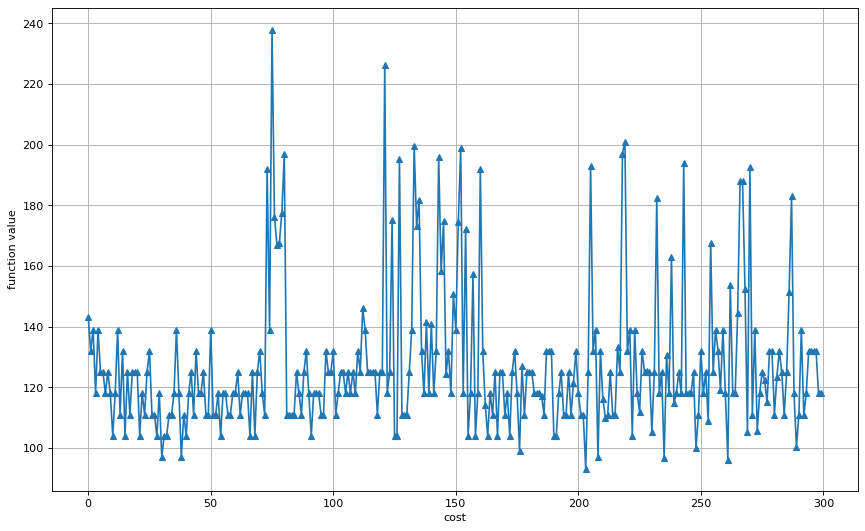

In [22]:
pl.figure(figsize=(13, 8), dpi=80)
pl.plot(np.squeeze(np.array(history)[:, 1]), "-^")
pl.xlabel("cost")
pl.ylabel("function value")
pl.grid(True)

## Global Minima 

In [23]:
gp.X[np.argmin(gp.y)], np.min(gp.y)

(array([ 0.7435, -3.    , -3.    ,  0.2236, -3.    ,  4.    , -3.    ,
        -3.    , -3.    , -0.8741]),
 93.09416654945785)

In [24]:
gp.get_hyper()

{'var': 4086.1656020667137, 'lengthscale': 8.009187372014189}